# Piezo Antenna

## Introduction

Pointing out:
 - antennae as a common concept for near-range orientation
 - mechanoreceptors, especially the johnston's organ
 - vibration sensitivity of antennae
 - prior approaches to construct a biomimetic antenna
     - results of these approaches
     - drawbacks of these approaches
 - what is different in this approach




Most insects utilize a pair of antennae to sense their near-range environment. When blindfolded these insects are still capable of climbing obstacles and finding footholds for their front legs using their antennae [[Dürr01]](https://www.ncbi.nlm.nih.gov/pubmed/22098903). Different types of mechanoreceptors present in each antenna, are involved to perform this kind of orientation. One of these receptors - the Johnston's organ - is correlated to the sensing of antennal vibrations [[JC96]](https://link.springer.com/article/10.1007/BF02346378).
As vibrations are characterized by their amplitude, frequency and phase, all further information about the origin of the vibration is encoded in these properties. This includes forces applied to the antenna on movement or on a contact with another object.
Prior approaches to construct a biomimetic antenna have proven, that vibration properties can be exploited to estimate a position of a contact on the antenna or material properties and texture of any touched object [[KM04]](http://www.ti.uni-bielefeld.de/downloads/publications/whisker3.pdf). .....

>Therefore an artificial antenna needs to be constructed that is capable of providing distance information of objects with sufficient precision and a small latency. For footstep planning, the robot needs to get an immediate feedback of it’s surroundings, especially when the knowledge is restricted to the range of the robot. In the hereinafter described experiment, the properties and performance of an antenna that utilizes a piezoelectric sensor gets explored. More precisely it is examined, whether the signal from this antenna contains the required distance estimation on objects it touches.

## Materials and Methods
### Experimental setup
### Data acquisition
### Analytical methods

First, the recorded data must be read and processed for the analysis.

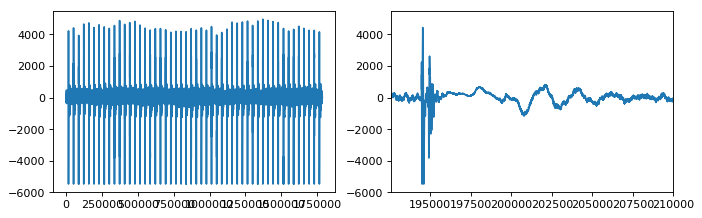

In [7]:
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import numpy as np
import os
import re

FRAMERATE = 0

# load and prepare the data
files = os.listdir('data')
rawdata = []
classes = []

# search folder for wav files
for f in files:
    if '.wav' not in f:
        continue
    fs, data = wav.read(os.path.join(data_dir, f))
    FRAMERATE = fs
    rawdata.append(data)
    # parse integers from filename (distance, speed, material)
    decoded_classes = [ int(s) for s in re.findall(r'-?\d+', f) ]
    classes.append(decoded_classes)

N_CLASSES = len(rawdata)

plt.figure(num=None, figsize=(10, 3), dpi=80)

plt.subplot(1, 2, 1)
plt.plot(rawdata[0])

plt.subplot(1, 2, 2)
plt.xlim((192599, 210000))
plt.plot(rawdata[0])

The records were stored by distance and motor speed. Each file contains 50 recorded contact events and these have to be cut out and stored separately for further processing.

### Extracting the peaks

The records were stored by distance and motor speed. Each file contains 50 recorded contact events and these have to be cut out and stored separately for further processing.

In [78]:
EXPECTED_CONTACTS = 50
THRESHOLD = 2000

data = []

for i in range(len(rawdata)):
    peaks  = np.abs(rawdata[0]) > THRESHOLD
    
'''
import peakutils

peeks = []
THRESHOLD = 2000
MAX_CONTACT_TIME = 5000
NEG_X_OFFSET = 0
POS_X_OFFSET = 4000
FRAGMENT_LENGTH = NEG_X_OFFSET + POS_X_OFFSET
DISTANCE_INDEX = 0
TOTAL_DISTANCES = 10

data = []
# this peaks array is just for the scatterplot to save the peaks of the last dataset
peaks = []
distance_values = []

for i in range(len(rawdata)):
    peaks = peakutils.peak.indexes(np.abs(rawdata[i]),
                              thres=THRESHOLD/max(rawdata[i]),
                              min_dist=MAX_CONTACT_TIME)
    contact_events = [ rawdata[i][peak-NEG_X_OFFSET:peak+POS_X_OFFSET] for peak in peaks ]
    
    if len(peaks) != EXPECTED_CONTACTS:
        print("Detected only {} peaks in dataset {}!".format(len(peaks), i))
    
    data.append(contact_events)
    # generate data labels
    distance_values.append([classes[i][DISTANCE_INDEX]] * len(peaks))

plt.figure(num=None, figsize=(10, 4), dpi=80)
plt.subplot('121')
plt.plot(rawdata[-1])
plt.scatter(peaks, [ rawdata[-1][i] for i in peaks ], color='r', marker='^')
plt.xlim((192599, 400000))
plt.subplot('122')

for i in range(5):
    xs = range(FRAGMENT_LENGTH * 5)[FRAGMENT_LENGTH * i:FRAGMENT_LENGTH * (i+1)]
    plt.plot(xs, data[i][i], label='dist {}'.format(distance_values[i][i]))

plt.legend()'''

[False False False ... False False False]


### Spectrogram

The spectrogram shows the time course of frequency power.

<Figure size 800x320 with 0 Axes>

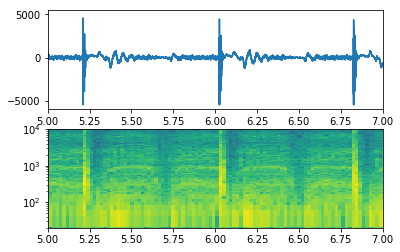

In [74]:
import scipy.signal as signal

SEGMENT_LEN = 1024


def generate_spectrogram(data):
    f, t, Sxx = signal.spectrogram(data,
                                 fs=FRAMERATE,
                                 scaling='density',
                                 mode='psd',
                                 nperseg=SEGMENT_LEN, 
                                 nfft=SEGMENT_LEN*2)
    Sxx = np.log(Sxx)
    return f, t, Sxx


def samples_to_time(num_samples):
    return np.array(range(num_samples)) / 44100.
    

f, t, Sxx = generate_spectrogram(rawdata[0])

plt.figure(num=None, figsize=(10, 4), dpi=80)
fig, ax = plt.subplots(2,1)
ax[1].set_ylim((20, 10000))
# show two seconds of the signals spectrogram
ax[0].set_xlim((5, 7))
ax[1].set_xlim((5, 7))
ax[0].plot(samples_to_time(len(rawdata[0])), rawdata[0])
ax[1].pcolormesh(t, f, Sxx, label='spectrogram i')
ax[1].set_yscale('log')

# Frequency spectra

In [ ]:
def generate_spectrum(data):
    f, Pxx  = signal.welch(data,
                           fs=FRAMERATE,
                           window='hann',
                           nperseg=SEGMENT_LEN,
                           nfft=SEGMENT_LEN*2)


mean_spectra = []
for i in range(N_CLASSES):
    for i in range(N_CLASSES):
        f, Pxx = generate_spectrum(rawdata[i])